Build a theoretical model of the LBTI point source interference pattern

Fit that model to the retrieved PSF

Fit that model to each PSF frame

Fit that model to Emakong frames

See if the retrieved phase offsets correspond with the retrieved x positions

In [56]:
%matplotlib inline
import os
import matplotlib.animation
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/Users/emolter/Python/ffmpeg'

from astropy.modeling.functional_models import AiryDisk2D, Cosine1D

In [57]:
pixscale_arcsec = 0.01064 #arcsec, lbti

## Theoretical model of LBTI PSF

In [58]:
def fringe_equation(x, k, I, phi, V):
    '''
    Interference pattern equation in one dimension
    
    Parameters
    ----------
    I: fringe intensity
    k: wavenumber
    x: modulator position (distance from center of pattern)
    V: source visibility
    phi: visibility phase offset
    
    Notes
    -----
    k*x = spatial frequency, baseline length/lambda
    phi/k = d, channel delay offset (distance units)
    '''
    return I*(1 + V*np.cos(k*x + phi))


def Rayleigh(B, wl):
    '''
    Rayleigh criterion for two-element interferometer
    B: baseline in meters
    wl: wavelength in microns
    returns angular separation in arcsec
    '''
    
    theta = 1.22 * wl*1e-6 / B
    return np.rad2deg(theta) * 3600


def lbti_psf(x, y, I0, phi, V=1., wl=4.78, D=8.4, B=14.4, pixscale=0.01064):
    '''
    Interferogram for two slits convolved with single-dish Airy ring as for LBTI.
    Simulates observations of a point source
    all defaults are correct for LBTI 4.8 micron observations
    
    Parameters
    ----------
    x, y: pixel grid, e.g. from np.meshgrid
    I0: total flux
    V: visibility amplitude
    phi: visibility phase (rad)
    wl: wavelength of observation (um)
    D: single-dish diameter (m)
    B: baseline length (m)
    pixscale: pixel scale of observations (arcsec/px)
    '''
    # make single dish model
    null = Rayleigh(D, wl) / pixscale
    singledish_model = AiryDisk2D(amplitude=1, x_0=0, y_0=0, radius=null)
    singledish = singledish_model(x, y)
    norm = np.sum(singledish)
    singledish = singledish/norm #make it sum to unity
    
    # convert k, x to m-1 and m
    k = 2*np.pi*pixscale / (np.rad2deg(np.arcsin(wl*1e-6 / B))*3600) #wavenumber in per arcsec
    x_arcsec = x[0]
    doubleslit = fringe_equation(x[0], k, I0, phi, V)
    total = singledish * doubleslit[np.newaxis, :]
    
    return total


## Bring in the real PSF and optimize

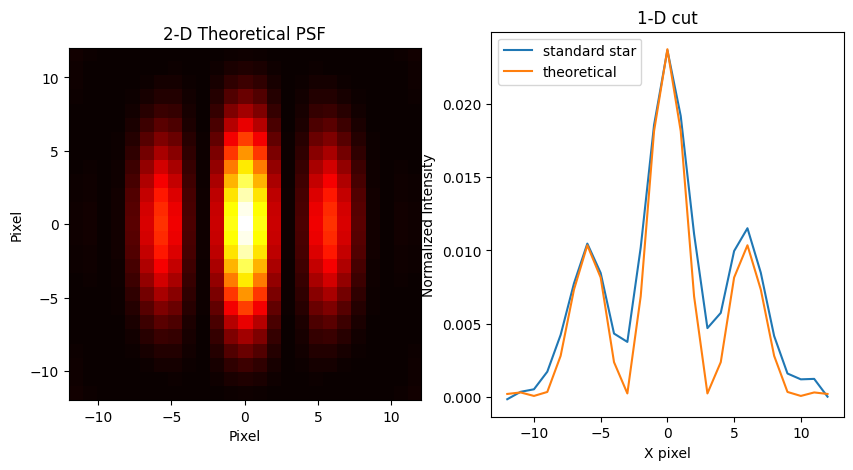

In [87]:
import pickle
import paths

with open(paths.data / 'lbti/psf_fittable_model.pkl', 'rb') as f:
    epsf = pickle.load(f)
i0, i1 = 10, 13
psf_cut = np.mean(epsf.data[i0:i1,:], axis = 0)

xdata = np.arange(psf_cut.size) - int(psf_cut.size/2)
xx, yy = np.meshgrid(xdata, xdata)
theory = lbti_psf(xx, yy, 1.6, 0.0,)
theory_cut = np.mean(theory[i0:i1,:], axis = 0)

fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,5))
ax0.imshow(theory, origin='lower', extent=[np.min(xdata), np.max(xdata), np.min(xdata), np.max(xdata)], cmap='hot')
ax0.set_xlabel('Pixel')
ax0.set_ylabel('Pixel')
ax0.set_title('2-D Theoretical PSF')
ax1.plot(xdata, psf_cut, label = 'standard star')
ax1.plot(xdata, theory_cut, label = 'theoretical')
ax1.set_xlabel('X pixel')
ax1.set_ylabel('Normalized Intensity')
ax1.set_title('1-D cut')
ax1.legend(loc='upper left')
plt.show()

np.save(paths.data / 'lbti' / 'theoretical_psf_1d_cut.npy', theory_cut)

## check if k is correct! is the pre-factor of pi the right thing to do? 
#is some 1.22 needed somewhere for some reason?
# is the effective wavelength correct?

[ 1.9553175   0.65034042  0.23947646 -0.24100506]


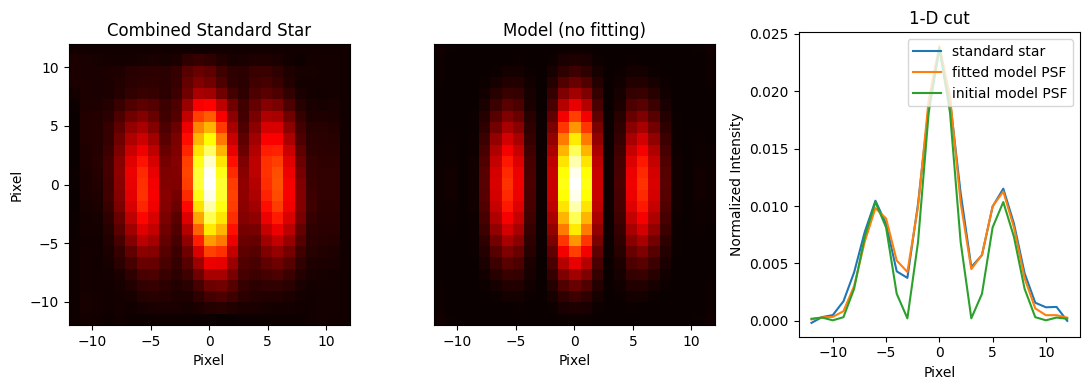

In [60]:
from scipy.optimize import curve_fit
def fit_eq(x, I0, V, phi, dx):
    xx, yy = np.meshgrid(x + dx, x)
    psf = lbti_psf(xx, yy, I0, phi, V=V)
    i0, i1 = 10, 13
    cut = np.mean(psf[i0:i1,:], axis = 0)
    return cut

popt, pcov = curve_fit(fit_eq, xdata, psf_cut, p0=[1.6, 1.0, 0.0, 0.0])
print(popt)
psf_out_cut = fit_eq(xdata, popt[0], popt[1], popt[2], popt[3])

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (11,4))
ax0.imshow(epsf.data, origin='lower', extent=[np.min(xdata), np.max(xdata), np.min(xdata), np.max(xdata)], cmap='hot')
ax0.set_title('Combined Standard Star')
ax0.set_xlabel('Pixel')
ax0.set_ylabel('Pixel')
ax1.imshow(theory, origin='lower', extent=[np.min(xdata), np.max(xdata), np.min(xdata), np.max(xdata)], cmap='hot')
ax1.set_yticks([])
ax1.set_xlabel('Pixel')
ax1.set_title('Model (no fitting)')
ax2.plot(xdata, psf_cut, label = 'standard star')
ax2.plot(xdata, psf_out_cut, label = 'fitted model PSF')
ax2.plot(xdata, theory_cut, label = 'initial model PSF')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Normalized Intensity')
ax2.set_title('1-D cut')

ax2.legend()
plt.tight_layout()
fig.savefig('diagnostic_plots/theoretical_interferogram/basic-psf-compare.png', dpi=300)
plt.show()


## bring in all the PSF frames and optimize each

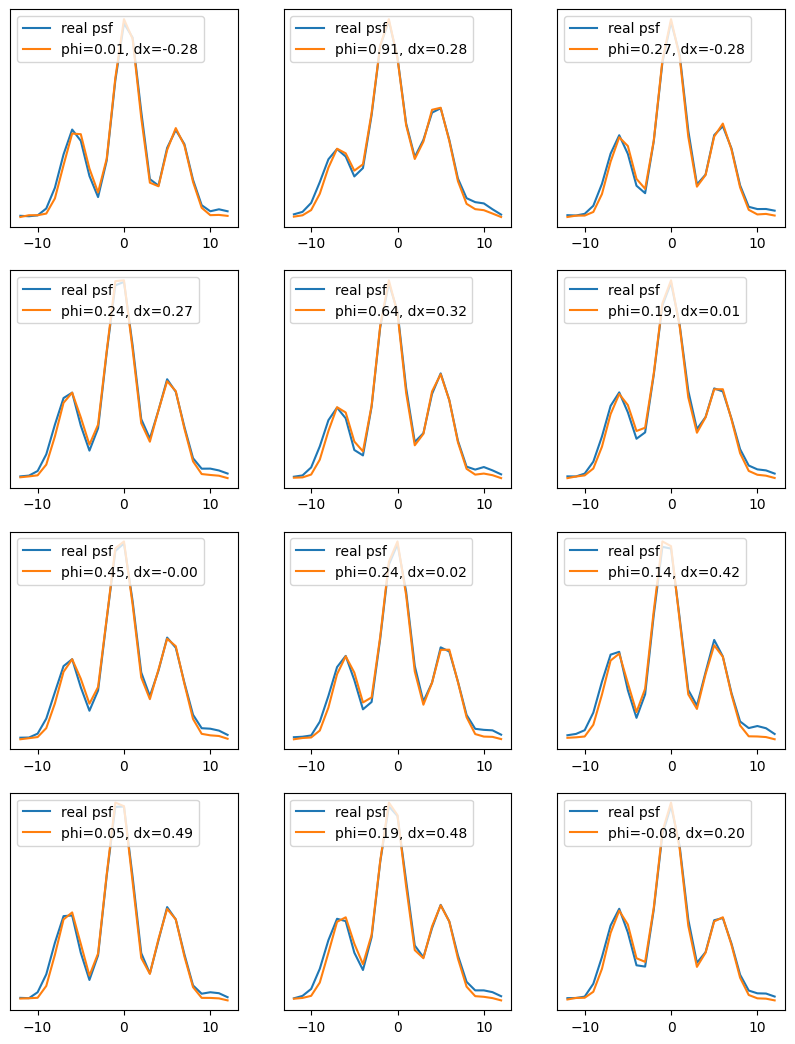

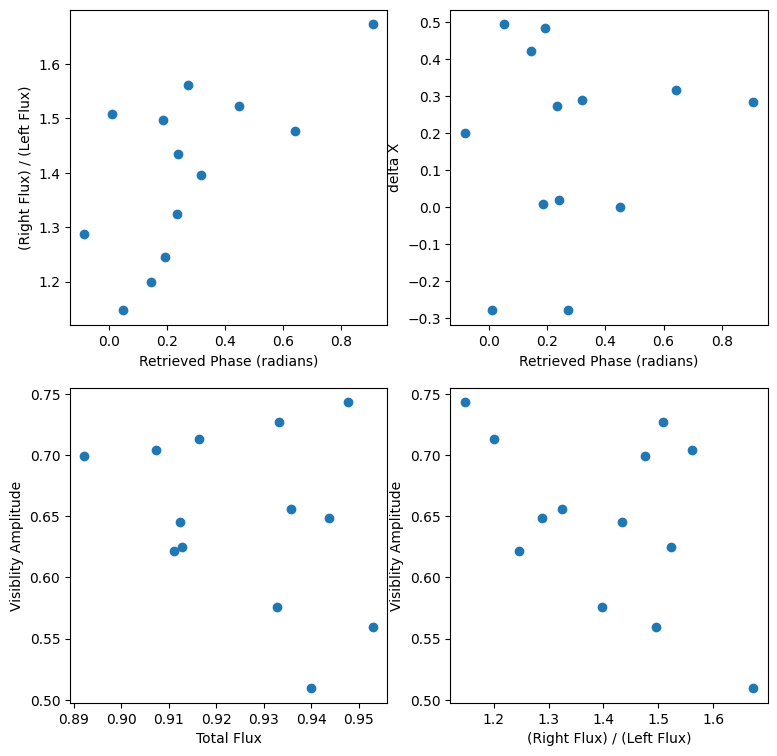

In [61]:
from astropy.io import fits
hdul = fits.open(paths.data / 'lbti/slctdPsfCube.fits')
psf_frames = hdul[0].data

popts, pcovs, cuts, fringe_ratios = [], [], [], []
for i, frame in enumerate(psf_frames):
    frame /= np.sum(frame)
    cut = np.mean(frame[i0:i1,:], axis = 0)
    left = np.sum(cut[2:8])
    right = np.sum(cut[14:20])
    fringe_ratios.append(right/left)
    #if i == 0:
    #    fig, ax = plt.subplots(1,1, figsize = (6,6))
    #    ax.plot(cut)
    #    plt.show()
    popt, pcov = curve_fit(fit_eq, xdata, cut, p0=[1.9, 1.0, 0.0, 0.0])
    popts.append(popt)
    pcovs.append(pcov)
    cuts.append(cut)

#I0, V, phi, dx
popts = np.array(popts)
I0s = popts[:,0]
Vs = popts[:,1]
phis = popts[:,2]
dxs = popts[:,3]

fig, axes = plt.subplots(4,3, figsize = (10, 13))
for i, ax in enumerate(axes.flatten()):
    
    theory = fit_eq(xdata, popts[i][0], popts[i][1], popts[i][2], popts[i][3])
    ax.plot(xdata, cuts[i], label='real psf')
    ax.plot(xdata, theory, label=f'phi={popts[i][2]:.2f}, dx={popts[i][3]:.2f}')
    ax.legend(loc='upper left')
    ax.set_yticks([])
    
plt.show()

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize = (9,9))
ax0.scatter(phis, fringe_ratios)
ax0.set_xlabel('Retrieved Phase (radians)')
ax0.set_ylabel('(Right Flux) / (Left Flux)')

ax1.scatter(phis, dxs)
ax1.set_xlabel('Retrieved Phase (radians)')
ax1.set_ylabel('delta X')

ax2.scatter(I0s, Vs)
ax2.set_xlabel('Total Flux')
ax2.set_ylabel('Visiblity Amplitude')

ax3.scatter(fringe_ratios, Vs)
ax3.set_xlabel('(Right Flux) / (Left Flux)')
ax3.set_ylabel('Visiblity Amplitude')

plt.show()

There is correlation between the fringe ratio and the retrieved phase, but no correlations between any other parameters. This is a good thing!

## same fitting procedure, same parameters, but on full 2-D image

[ I0, V, phi, dx, dy, rot]
[ 1.99229836  0.65283684  0.29697692 -0.25622132 -0.10390857 -3.4623799 ]


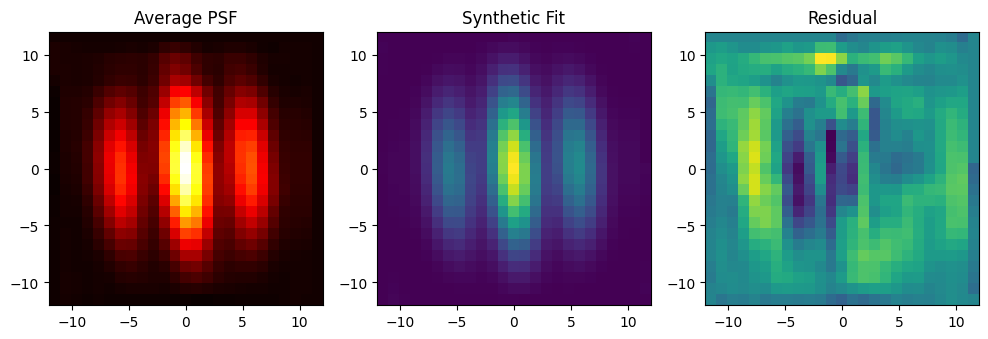

In [62]:
from scipy import ndimage
# hack curve_fit to operate on 2-D data
# see here: https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/#:~:text=The%20scipy.,total%20number%20of%20data%20points.
# For a two-dimensional array of data, Z, 
# calculated on a mesh grid (X, Y), 
# this can be achieved efficiently using the ravel method:

def func2d(x, I0, V, phi, dx, dy, rotang=-3.3):
    '''
    here x is (2, N) where N is number of data points
    '''
    sz=int(np.sqrt(x[0].size))
    xx = (x[0] + dx).reshape((sz,sz))
    yy = (x[1] + dy).reshape((sz,sz))
    psf = lbti_psf(xx, yy, I0, phi, V=V)
    psf = ndimage.rotate(psf, rotang, reshape=False)
    
    return psf.ravel()


x_flat = np.vstack((xx.ravel(), yy.ravel()))
psf_flat = epsf.data.ravel()
sz=int(np.sqrt(x_flat[0].size))
popt, pcov = curve_fit(func2d, x_flat, psf_flat, p0=[1.9, 1.0, 0.0, 0.0, 0.0, -3.5])
print('[ I0, V, phi, dx, dy, rot]')
print(popt)

psf_opt_flat = func2d(x_flat, popt[0], popt[1], popt[2], popt[3], popt[4])
psf_opt = psf_opt_flat.reshape((sz,sz))


fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (12,5))
ax0.imshow(epsf.data, origin='lower', extent=[np.min(xdata), np.max(xdata), np.min(xdata), np.max(xdata)], cmap='hot')
ax0.set_title('Average PSF')
ax1.imshow(psf_opt, origin='lower', extent=[np.min(xdata), np.max(xdata), np.min(xdata), np.max(xdata)])
ax1.set_title('Synthetic Fit')
ax2.imshow(epsf.data - psf_opt, origin='lower', extent=[np.min(xdata), np.max(xdata), np.min(xdata), np.max(xdata)])
ax2.set_title('Residual')
fig.savefig('diagnostic_plots/theoretical_interferogram/fit-psf-2d.png', dpi=300)
plt.show()

## loop the 2-D fits over all PSF frames

In [63]:
popts2d, pcovs2d = [], []
frames_opt = np.empty(psf_frames.shape)
for i, frame in enumerate(psf_frames):
    
    frame_flat = frame.ravel()
    popt, pcov = curve_fit(func2d, x_flat, frame_flat, p0=[1.0, 1.0, 0.0, 0.0, 0.0, -3.5])
    popts2d.append(popt)
    pcovs2d.append(pcov)
    sz = int(np.sqrt(frame_flat.size))
    frames_opt[i] = func2d(x_flat, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]).reshape((sz, sz))

(5, 3)


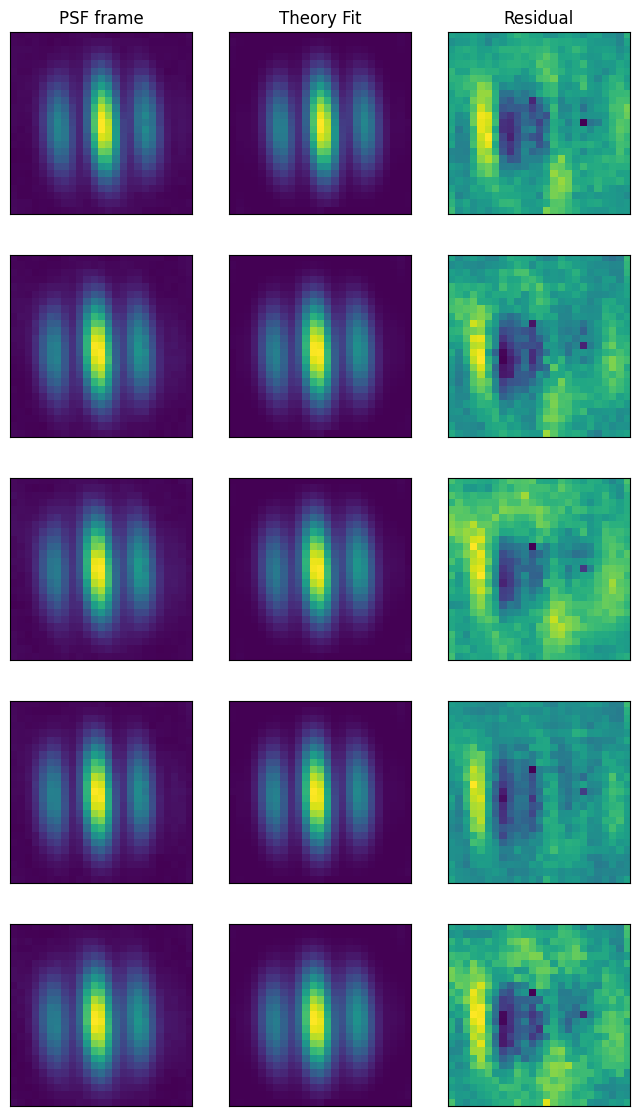

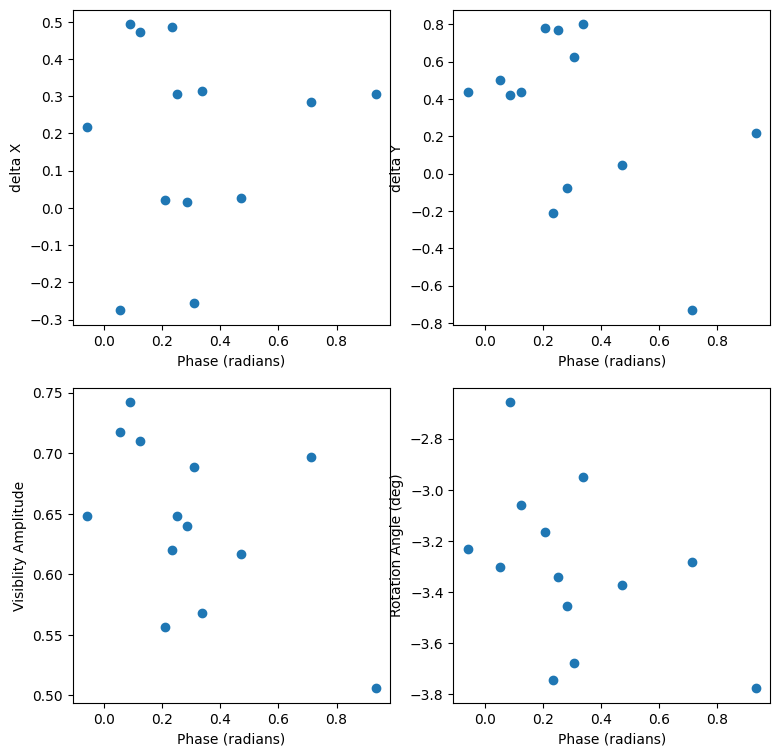

In [64]:
#I0, V, phi, dx, dy, rotang
popts2d = np.array(popts2d)
I0s = popts2d[:,0]
Vs = popts2d[:,1]
phis = popts2d[:,2]
dxs = popts2d[:,3]
dys = popts2d[:,4]
rots = popts2d[:,5]

fig, axes = plt.subplots(5,3, figsize = (8, 14))
print(axes.shape)
for i, ax in enumerate(axes.flatten()):
    
    if i % 3 == 0:
        ax.imshow(psf_frames[i], origin='lower')
    elif i % 3 == 1:
        ax.imshow(frames_opt[i-1], origin='lower')
    elif i % 3 == 2:
        ax.imshow(psf_frames[i-2] - frames_opt[i-2], origin='lower')
        
    if i == 0:
        ax.set_title('PSF frame')
    if i == 1:
        ax.set_title(f'Theory Fit')
    if i == 2:
        ax.set_title('Residual')
        
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize = (9,9))
ax0.scatter(phis, dxs)
ax0.set_xlabel('Phase (radians)')
ax0.set_ylabel('delta X')

ax1.scatter(phis, dys)
ax1.set_xlabel('Phase (radians)')
ax1.set_ylabel('delta Y')

ax2.scatter(phis, Vs)
ax2.set_xlabel('Phase (radians)')
ax2.set_ylabel('Visiblity Amplitude')

ax3.scatter(phis, rots)
ax3.set_xlabel('Phase (radians)')
ax3.set_ylabel('Rotation Angle (deg)')

plt.show()

Now that we are accounting for the asymmetry in the PSF when there is a slight phase offset, the delta x values should be uncorrelated with the phase. And indeed, this is what we see!

These retrieved parameters can be used to constrain the model PSF we will use for Emakong; for example, we should just take the average rotation angle from here and not allow it to change for Emakong. It is not yet clear to me whether this should also be done for the visibility amplitude.

In [65]:
print(f'Average rotation angle: {np.mean(rots):.2f} +/- {np.std(rots):.2f}')
print(f'Average total flux: {np.mean(I0s):.2f} =/- {np.std(I0s):.2f}')
print(f'Average visibility amplitude: {np.mean(Vs):.2f} +/- {np.std(Vs):.2f}')

Average rotation angle: -3.31 +/- 0.31
Average total flux: 0.93 =/- 0.01
Average visibility amplitude: 0.64 +/- 0.07


This also gives us a more accurate estimate of the spread in x, y positions you can expect for a high-SNR detection of a point source.

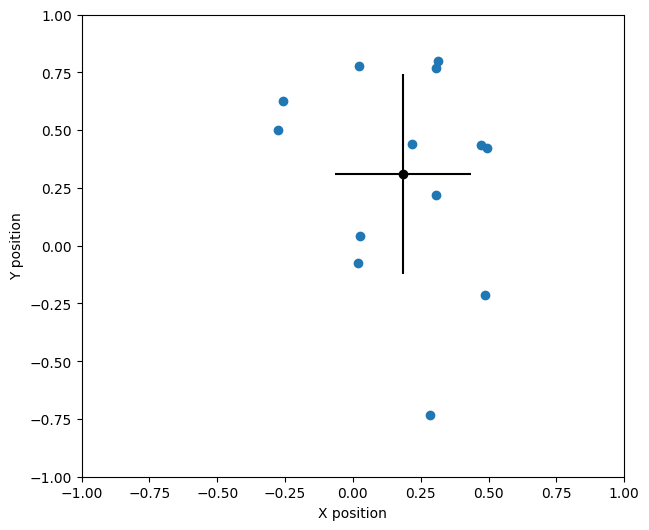

In [66]:
fig, ax = plt.subplots(1,1, figsize = (7,6))
ax.scatter(dxs, dys)
ax.errorbar(np.mean(dxs), np.mean(dys), xerr=np.std(dxs), yerr=np.std(dys), marker = 'o', color = 'k')
ax.set_xlim([-1,1])
ax.set_ylim([-1, 1])
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
plt.show()

## try this workflow on real Emakong data

In [67]:
from pylanetary.utils import rebin
disksub_data = np.load(paths.data / 'lbti/disksub_frames.npy')
disksub_frames = np.array([rebin(frame, 1/5) for frame in disksub_data]) #[:,30:100, 50:120]

frame = disksub_frames[0]
maxpx = np.unravel_index(np.argmax(frame), frame.shape)

#fig, ax = plt.subplots(1,1, figsize = (6,6))
#ax.imshow(frame, origin = 'lower')
#ax.scatter(maxpx[1], maxpx[0], color='red')
#plt.show()

[-75. -74. -73. -72. -71. -70. -69. -68. -67. -66. -65. -64. -63. -62.
 -61. -60. -59. -58. -57. -56. -55. -54. -53. -52. -51. -50. -49. -48.
 -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37. -36. -35. -34.
 -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23. -22. -21. -20.
 -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.
  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.
   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.
  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.
  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.
  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.
  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.]
[ I0, V, phi, dx, dy, rotang]
[ 1.55476121e+05  3.86494722e-01 -1.92239562e-01 -1.18423415e+01
  1.00122205e+01 -2.71530578e+00]


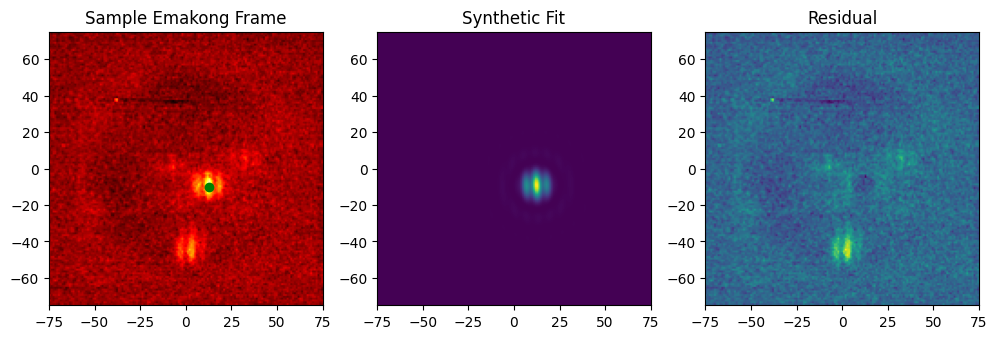

In [68]:
xdata = np.arange(frame[0].size) - (frame[0].size - 1)/2
print(xdata)
xx, yy = np.meshgrid(xdata, xdata)
x_flat = np.vstack((xx.ravel(), yy.ravel()))
frame_flat = frame.ravel()
sz=int(np.sqrt(x_flat[0].size))
dx0 = xdata[maxpx[1]]
dy0 = xdata[maxpx[0]]
popt, pcov = curve_fit(func2d, x_flat, frame_flat, p0=[1e5, 0.65, 0.0, -dx0, -dy0, -3.3]) #I0, V, phase, dx, dy, rotang
print('[ I0, V, phi, dx, dy, rotang]')
print(popt)

frame_opt_flat = func2d(x_flat, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])
#frame_opt_flat = func2d(x_flat, 1e5, 0.65, 0.0, -dx0, -dy0) #a priori model
frame_opt = frame_opt_flat.reshape((sz,sz))


fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (12,5))
ax0.imshow(frame, origin='lower', extent=[np.min(xdata), np.max(xdata), np.min(xdata), np.max(xdata)], cmap='hot')
ax0.scatter(dx0, dy0, color='green')
ax0.set_title('Sample Emakong Frame')
ax1.imshow(frame_opt, origin='lower', extent=[np.min(xdata), np.max(xdata), np.min(xdata), np.max(xdata)])
ax1.set_title('Synthetic Fit')
ax2.imshow(frame - frame_opt, origin='lower', extent=[np.min(xdata), np.max(xdata), np.min(xdata), np.max(xdata)])
ax2.set_title('Residual')
fig.savefig('diagnostic_plots/theoretical_interferogram/sample_ema_fit.png', dpi=300)
plt.show()

### looks good. loop over all frames

In [69]:
from scipy import signal
z = 1
bounds = ([-np.inf, 0.2, -np.pi, -np.inf, -np.inf, -90] , 
         [np.inf, 1.0, np.pi, np.inf, np.inf, 90])

popts_ema, pcovs_ema = [], []
dx_guess = []
ema_opt = np.empty(disksub_frames.shape)
for i, frame in enumerate(disksub_frames):
    frame_outlierreject = signal.medfilt2d(frame, kernel_size=z*3)
    maxpx = np.unravel_index(np.argmax(frame_outlierreject), frame.shape)
    frame_flat = frame.ravel()
    sz=int(np.sqrt(x_flat[0].size))
    dx0 = xdata[maxpx[1]]
    dy0 = xdata[maxpx[0]]
    dx_guess.append(dx0)
    popt, pcov = curve_fit(func2d, x_flat, frame_flat, p0=[1e5, 0.65, 0.0, -dx0, -dy0, -3.0], bounds=bounds) #I0, V, phase, dx, dy, rotang
    popts_ema.append(popt)
    pcovs_ema.append(pcov)
    ema_opt[i] = func2d(x_flat, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]).reshape((sz, sz)) #I0, V, phase, dx, dy

(12, 3)


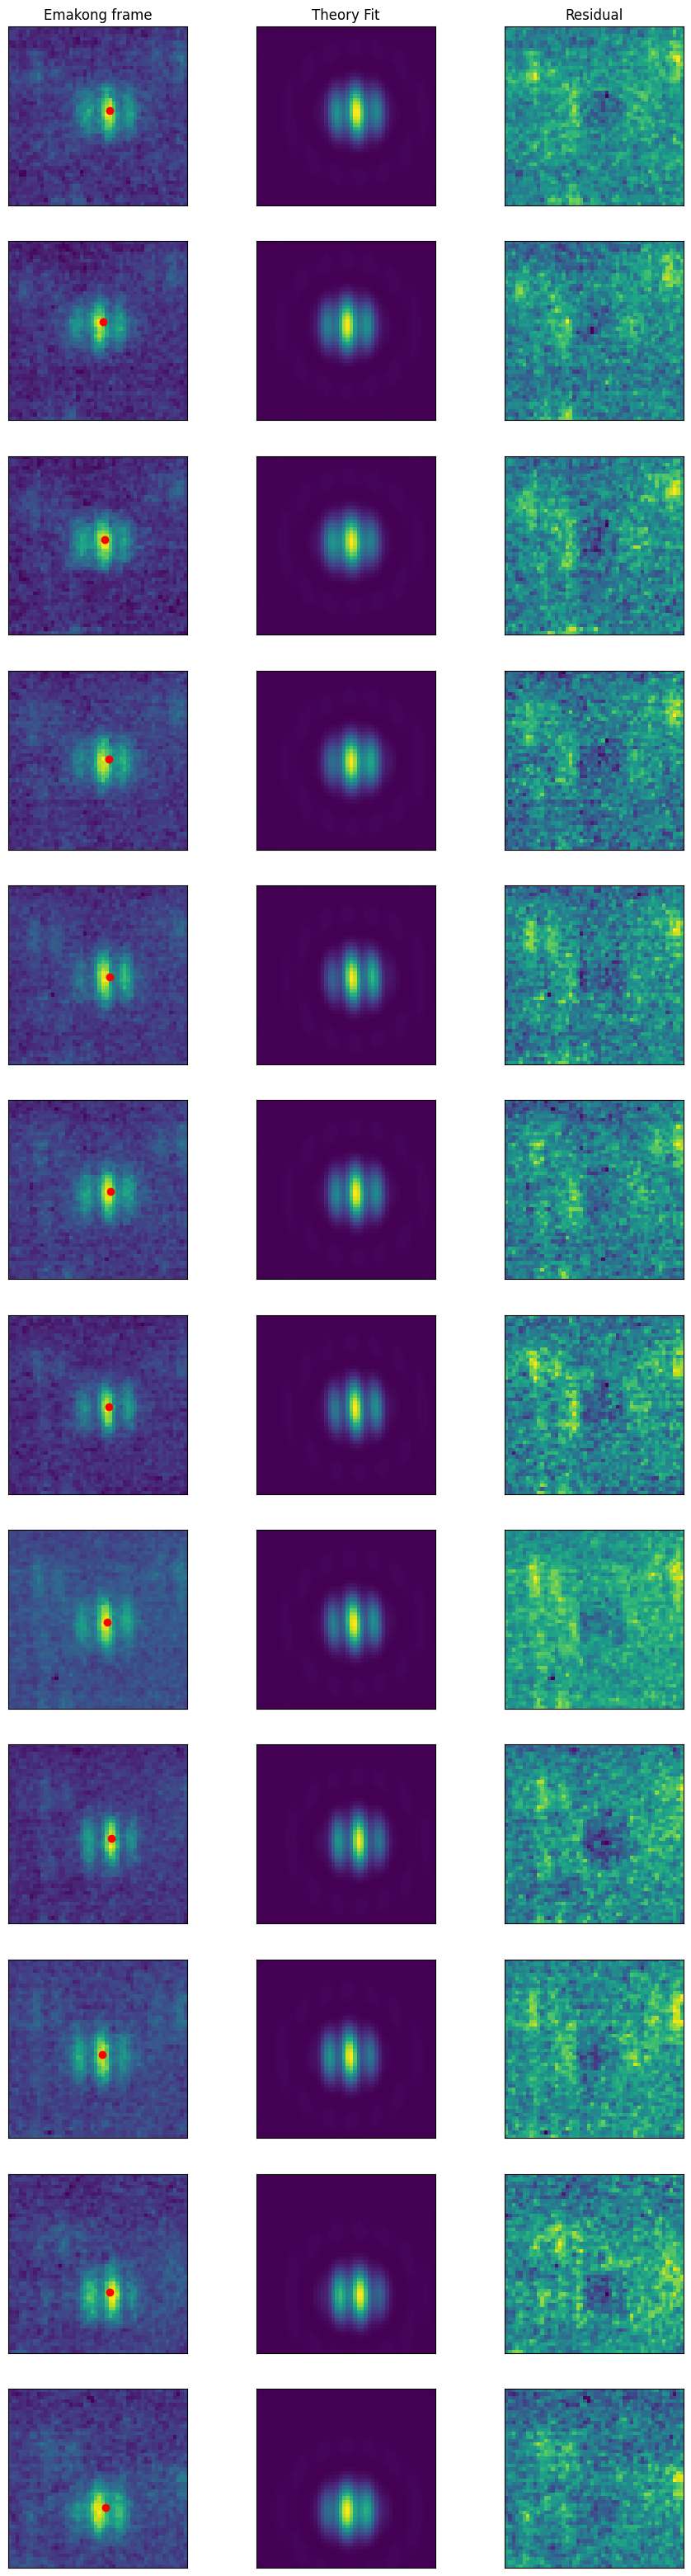

In [70]:
#I0, V, phi, dx, dy, rotang
popts_ema = np.array(popts_ema)
I0s = popts_ema[:,0]
Vs = popts_ema[:,1]
phis = popts_ema[:,2]
dxs = popts_ema[:,3]
dys = popts_ema[:,4]
rotangs = popts_ema[:,5]

pcovs_ema = np.array(pcovs_ema)
stds_ema = np.array([np.sqrt(np.diag(cov)) for cov in pcovs_ema])
sig_I0s = stds_ema[:,0]
sig_Vs = stds_ema[:,1]
sig_phis = stds_ema[:,2]
sig_dxs = stds_ema[:,3]
sig_dys = stds_ema[:,4]
sig_rots = stds_ema[:,5]

fig, axes = plt.subplots(12,3, figsize = (11, 40))
print(axes.shape)
for i, ax in enumerate(axes.flatten()):
    
    if i % 3 == 0:
        ax.imshow(disksub_frames[i, 40:90, 60:110], origin='lower')
        ax.scatter(-dxs[i]+76-60, -dys[i]+76-40, color='red')
    elif i % 3 == 1:
        ax.imshow(ema_opt[i-1, 40:90, 60:110], origin='lower')
    elif i % 3 == 2:
        ax.imshow(disksub_frames[i-2, 40:90, 60:110] - ema_opt[i-2, 40:90, 60:110], origin='lower')
        
    if i == 0:
        ax.set_title('Emakong frame')
    if i == 1:
        ax.set_title(f'Theory Fit')
    if i == 2:
        ax.set_title('Residual')
        
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig('diagnostic_plots/emakong_psf_fits.png', dpi=300)
plt.show()

In [71]:
print('phi', np.mean(phis), np.std(phis))
print('rotang', np.mean(rotangs), np.std(rotangs))
print('V', np.mean(Vs), np.std(Vs))

phi 0.10894604609512172 0.6565765545233389
rotang -1.6742664040126085 0.8498654913830463
V 0.4342373140348526 0.07784221311579156


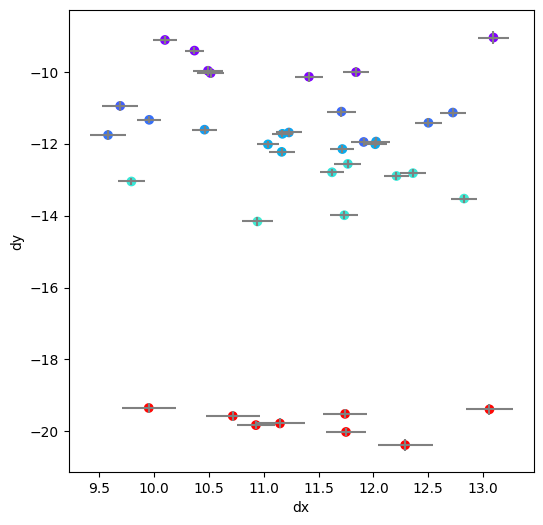

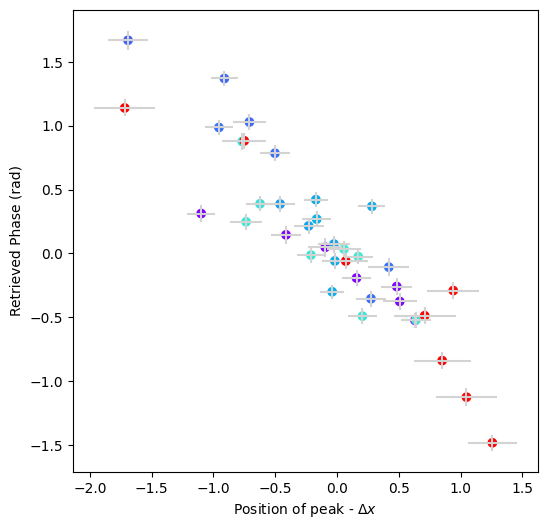

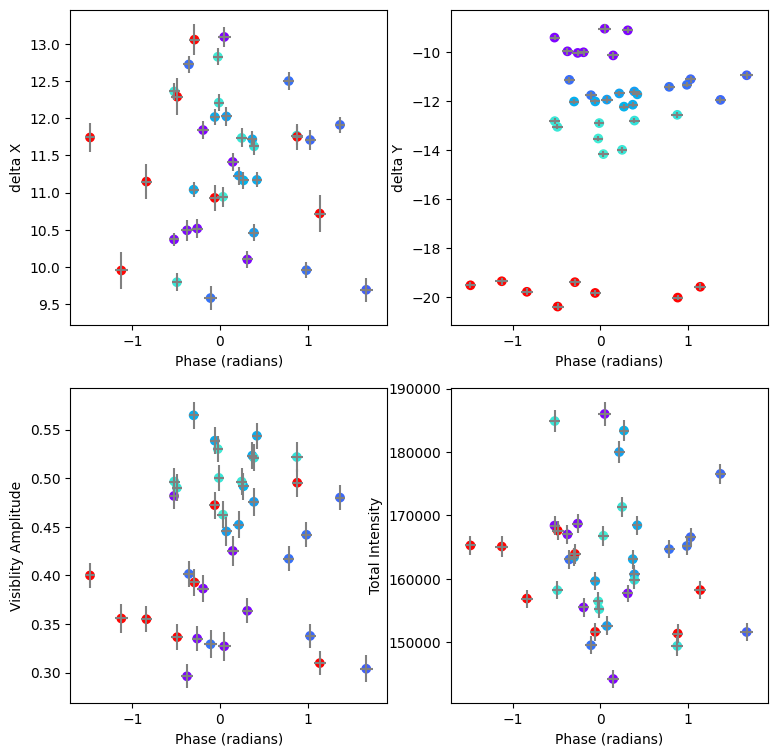

In [72]:
lucky_angles = np.load(paths.data / 'lbti/lucky_angles.npy')
lucky_times = np.load(paths.data / 'lbti/lucky_times.npy', allow_pickle=True)

fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.scatter(-dxs, -dys, c=lucky_angles, cmap='rainbow')
ax.errorbar(-dxs, -dys, xerr=sig_dxs, yerr=sig_dys, linestyle = '', color='gray')
ax.set_xlabel('dx')
ax.set_ylabel('dy')
plt.show()

fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.scatter(np.array(dx_guess)+dxs, phis, c=lucky_angles, cmap='rainbow')
ax.errorbar(np.array(dx_guess)+dxs, phis, xerr=sig_dxs, yerr=sig_phis, linestyle = '', color='lightgray')
ax.set_xlabel(r'Position of peak - $\Delta x$')
ax.set_ylabel('Retrieved Phase (rad)')
plt.show()

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize = (9,9))
ax0.scatter(phis, -dxs, c=lucky_angles, cmap = 'rainbow')
ax0.errorbar(phis, -dxs, yerr=sig_dxs, xerr=sig_phis, linestyle = '', color='gray')
ax0.set_xlabel('Phase (radians)')
ax0.set_ylabel('delta X')

ax1.scatter(phis, -dys, c=lucky_angles, cmap = 'rainbow')
ax1.errorbar(phis, -dys, xerr=sig_phis, yerr=sig_dys, linestyle = '', color='gray')
ax1.set_xlabel('Phase (radians)')
ax1.set_ylabel('delta Y')

ax2.scatter(phis, Vs, c=lucky_angles, cmap = 'rainbow')
ax2.errorbar(phis, Vs, xerr=sig_phis, yerr=sig_Vs, linestyle = '', color='gray')
ax2.set_xlabel('Phase (radians)')
ax2.set_ylabel('Visiblity Amplitude')

ax3.scatter(phis, I0s, c=lucky_angles, cmap = 'rainbow')
ax3.errorbar(phis, I0s, xerr=sig_phis, yerr=sig_I0s, linestyle = '', color='gray')
ax3.set_xlabel('Phase (radians)')
ax3.set_ylabel('Total Intensity')

fig.savefig('diagnostic_plots/emakong_fitted_params.png', dpi=300)
plt.show()

### apply these dx, dy to the original image to improve disk stack (somehow)

### get lat-lon values based on these dx, dy

In [73]:
!pip install git+https://github.com/keflavich/image_registration.git
from pylanetary.navigation import Nav
from pylanetary.utils import Body

  Cloning https://github.com/keflavich/image_registration.git to /private/var/folders/g0/r491pzqx4kx0tfmpx8970ntm0000gn/T/pip-req-build-28scv147
  Running command git clone --filter=blob:none --quiet https://github.com/keflavich/image_registration.git /private/var/folders/g0/r491pzqx4kx0tfmpx8970ntm0000gn/T/pip-req-build-28scv147
  Resolved https://github.com/keflavich/image_registration.git to commit 6cc4c818eed430efb0bc51591ec2e21fbdf4aa5f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


-11.357394836768405 0.9508903085606791
13.326475375662964 3.5134363229527388
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
New image will be 1767 by 883 pixels
Pixel scale 6.489281 km = 4.901852 pixels per degree


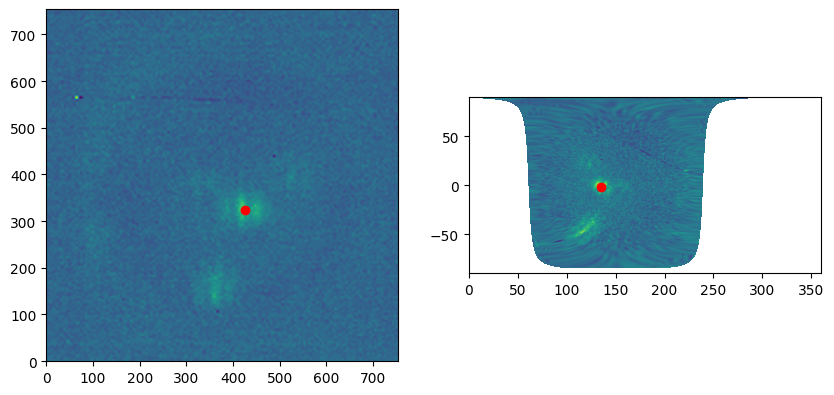

(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)
(755, 755)


In [74]:
z = 5
print(np.mean(dxs), np.std(dxs))
print(np.mean(dys), np.std(dys))
emakong_lon, emakong_lat = [], []
for i, obstime in enumerate(lucky_times):
    
    angle = lucky_angles[i]
    frame = disksub_data[i] #these have already been shifted to "center" in combined-disk-solution.ipynb
    print(frame.shape)
    
    ## new planetnav workflow
    io = Body('Io', epoch=obstime, location='G83') #Keck
    # adjust north pole angle according to parallactic angle
    npang = io.ephem['NPole_ang']
    io.ephem['NPole_ang'] = (npang - angle)%360
    nav = Nav(frame, io, pixscale_arcsec/z)
    
    dxe, dye = -dxs[i]*z + frame.shape[0]/2, -dys[i]*z + frame.shape[1]/2
    lat_ema = nav.lat_g[int(np.around(dye)), int(np.around(dxe))]
    lon_ema = nav.lon_w[int(np.around(dye)), int(np.around(dxe))]
    emakong_lat.append(lat_ema)
    emakong_lon.append(lon_ema)
    
    if i == 10:
        proj, _ = nav.reproject()
        fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,6))
        ax0.imshow(nav.data, origin='lower')
        ax0.scatter(dxe, dye, color='red')
        ax1.imshow(proj, origin ='lower', extent = [0, 360, -90, 90])
        ax1.scatter(lon_ema, lat_ema, color = 'red')
        plt.show()

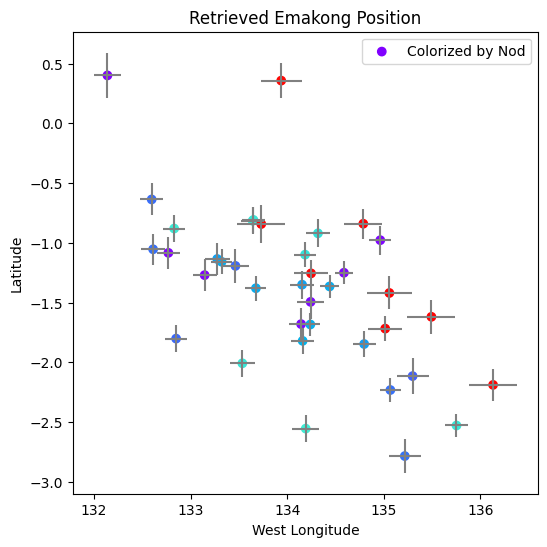

Latitude -1.3698604734257582 +/- 0.6689225258699657
Longitude 134.09679075277373 +/- 0.9363142828832803


In [75]:
fig, ax0 = plt.subplots(1,1, figsize = (6,6))
ax0.errorbar(emakong_lon, emakong_lat, xerr=sig_dxs, yerr=sig_dys, linestyle = '', color='gray')
ax0.scatter(emakong_lon, emakong_lat, c=lucky_angles, cmap='rainbow', label='Colorized by Nod')
ax0.set_xlabel('West Longitude')
ax0.set_ylabel('Latitude')
ax0.set_title('Retrieved Emakong Position')
ax0.legend()
fig.savefig('diagnostic_plots/theoretical_interferogram/retrieved_latlon.png', dpi=300)
plt.show()

print(f'Latitude {np.mean(emakong_lat)} +/- {np.std(emakong_lat)}')
print(f'Longitude {np.mean(emakong_lon)} +/- {np.std(emakong_lon)}')

out = np.array([emakong_lon, emakong_lat])
np.save(paths.data / 'latlon_theoretical-interferogram.npy', out)

# Fit the second feature

Try fitting the secondary feature in the residual maps using same workflow

(38, 151, 151) (38, 151, 151)


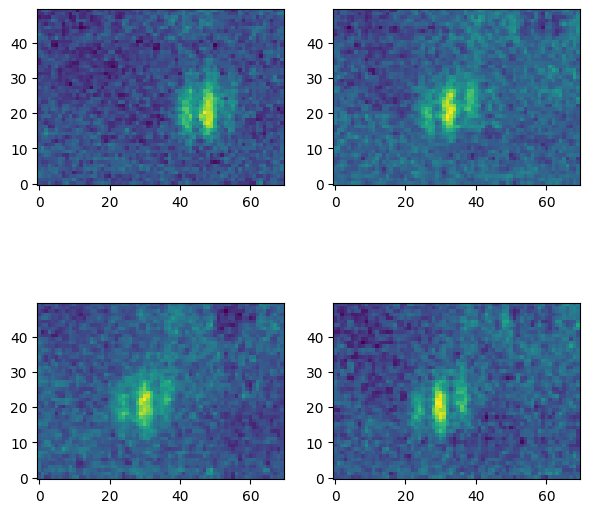

In [76]:
print(disksub_frames.shape, ema_opt.shape)

residuals = disksub_frames - ema_opt

fig, axes = plt.subplots(2,2, figsize = (7,7))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(residuals[-i,10:60, 30:100], origin='lower')
plt.show()

popts_second, pcovs_second = [], []
dx_guess = []
second_opt = np.empty(residuals.shape)
for i, frame in enumerate(residuals):
    frame_outlierreject = signal.medfilt2d(frame, kernel_size=z*3)
    maxpx = np.unravel_index(np.argmax(frame_outlierreject), frame.shape)
    frame_flat = frame.ravel()
    sz=int(np.sqrt(x_flat[0].size))
    dx0 = xdata[maxpx[1]]
    dy0 = xdata[maxpx[0]]
    dx_guess.append(dx0)
    popt, pcov = curve_fit(func2d, x_flat, frame_flat, p0=[1e5, 0.65, 0.0, -dx0, -dy0, -3.0], bounds=bounds) #I0, V, phase, dx, dy, rotang
    popts_second.append(popt)
    pcovs_second.append(pcov)
    second_opt[i] = func2d(x_flat, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]).reshape((sz, sz)) #I0, V, phase, dx, dy

(12, 3)


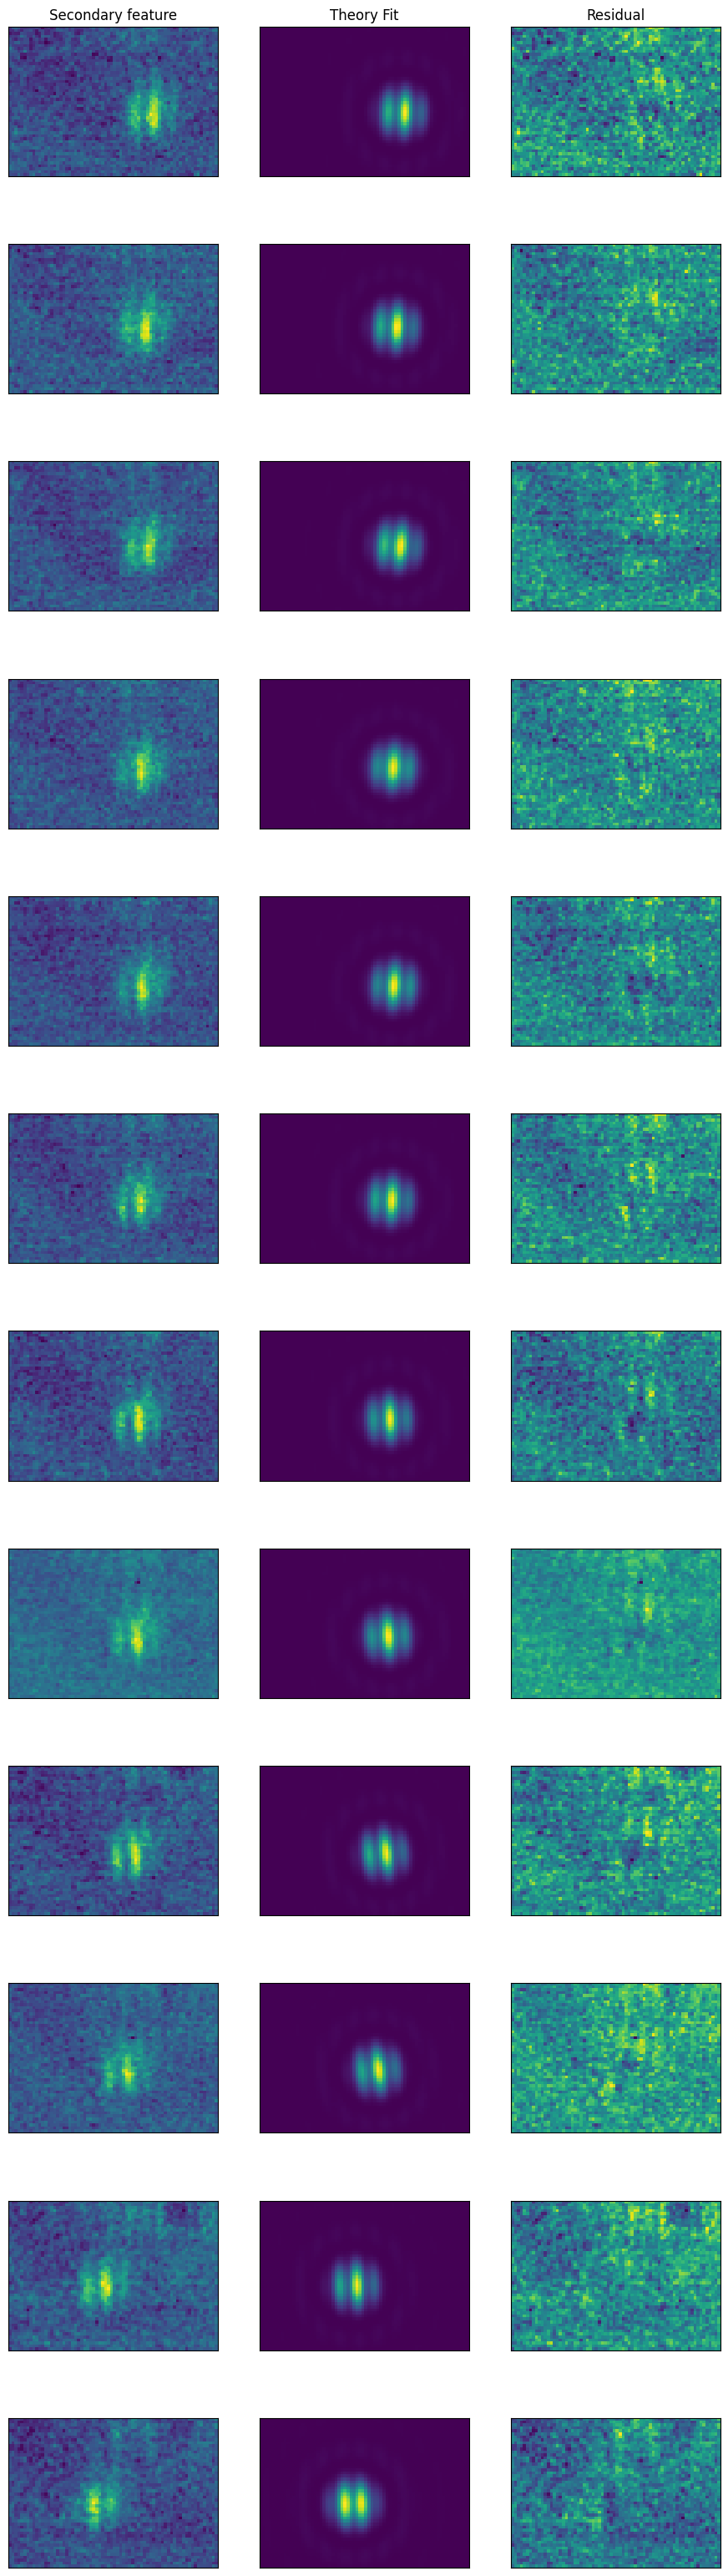

In [77]:
#I0, V, phi, dx, dy, rotang
popts_second = np.array(popts_second)
I0ss = popts_second[:,0]
Vss = popts_second[:,1]
phiss = popts_second[:,2]
dxss = popts_second[:,3]
dyss = popts_second[:,4]
rotangss = popts_second[:,5]

pcovs_second = np.array(pcovs_second)
stds_second = np.array([np.sqrt(np.diag(cov)) for cov in pcovs_second])
sig_I0ss = stds_second[:,0]
sig_Vss = stds_second[:,1]
sig_phiss = stds_second[:,2]
sig_dxss = stds_second[:,3]
sig_dyss = stds_second[:,4]
sig_rotss = stds_second[:,5]

fig, axes = plt.subplots(12,3, figsize = (11, 40))
print(axes.shape)
for i, ax in enumerate(axes.flatten()):
    
    if i % 3 == 0:
        ax.imshow(residuals[i,10:60, 30:100], origin='lower')
    elif i % 3 == 1:
        ax.imshow(second_opt[i-1,10:60, 30:100], origin='lower')
    elif i % 3 == 2:
        ax.imshow(residuals[i-2,10:60, 30:100] - second_opt[i-2,10:60, 30:100], origin='lower')
        
    if i == 0:
        ax.set_title('Secondary feature')
    if i == 1:
        ax.set_title(f'Theory Fit')
    if i == 2:
        ax.set_title('Residual')
        
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig('diagnostic_plots/secondary_psf_fits.png', dpi=300)
plt.show()

In [78]:
print('phi', np.mean(phiss), np.std(phiss))
print('V', np.mean(Vss), np.std(Vss))
print('rotang', np.mean(rotangss), np.std(rotangss))

phi -0.6830397327745238 0.8311440592267122
V 0.4154190843066499 0.0823951642419731
rotang -0.05342639691422533 3.3194763164958627


In [79]:
# fit differences to quadratic model
'''https://docs.scipy.org/doc/scipy/reference/generated/scipy.odr.polynomial.html'''
from scipy import odr
diffx = dxs-dxss
diffy = dys-dyss
poly_model = odr.polynomial(3)  # using third order polynomial model
data = odr.Data(diffy, diffx)
odr_obj = odr.ODR(data, poly_model)
output = odr_obj.run()
polyn = np.poly1d(output.beta[::-1])

xx= polyn(diffy)
yyy = np.linspace(np.sort(diffy)[0], np.sort(diffy)[-1], 500)
xxx = polyn(yyy)

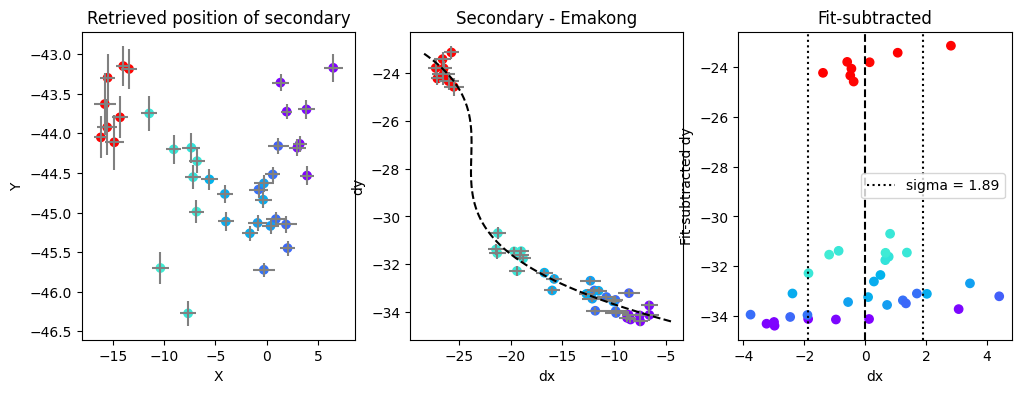

In [80]:
zz=diffx-xx
stddev_zz = np.std(zz)

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (12,4))
ax0.scatter(-dxss, -dyss, c=lucky_angles, cmap='rainbow')
ax0.errorbar(-dxss, -dyss, xerr=sig_dxss, yerr=sig_dyss, linestyle = '', color='gray')
ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_title('Retrieved position of secondary')

ax1.scatter(dxs-dxss, dys-dyss, c=lucky_angles, cmap='rainbow')
#ax1.plot(dxs-dxss, dys-dyss, linestyle='--', color='k')
ax1.errorbar(dxs-dxss, dys-dyss, 
             xerr=np.sqrt(sig_dxss**2 + sig_dxs**2), 
             yerr=np.sqrt(sig_dyss**2 + sig_dys**2), 
             linestyle = '', 
             color='gray')
ax1.plot(xxx, yyy, color = 'k', linestyle = '--')
ax1.set_xlabel('dx')
ax1.set_ylabel('dy')
ax1.set_title('Secondary - Emakong')

ax2.scatter(zz, diffy, c=lucky_angles, cmap='rainbow')
ax2.axvline(0, linestyle='--', color='k')
ax2.axvline(stddev_zz, linestyle=':', color='k', label=f'sigma = {stddev_zz:.2f}')
ax2.axvline(-stddev_zz, linestyle=':', color='k')
ax2.set_xlabel('dx')
ax2.set_ylabel('Fit-subtracted dy')
ax2.legend()
ax2.set_title('Fit-subtracted')

plt.show()

4.563785669928838 6.809525797769481
44.42792900420837 0.7642265023575953
New image will be 1767 by 883 pixels
Pixel scale 6.489229 km = 4.901892 pixels per degree


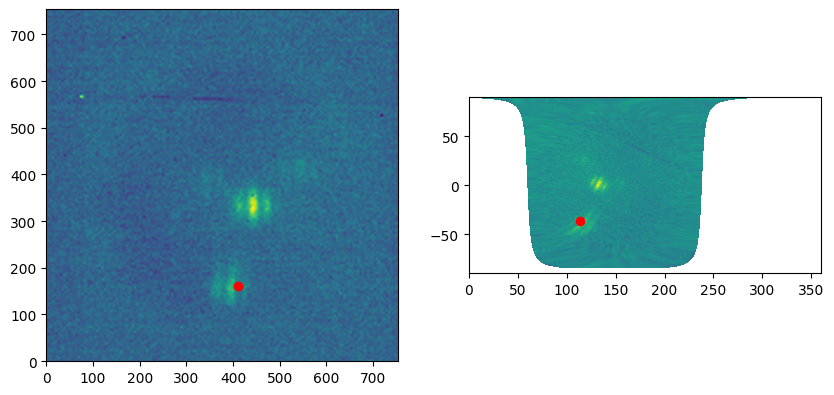

In [81]:
## are the x-position retrievals any closer to good though?
## need to go to lat-lon space for that

z = 5
print(np.mean(dxss), np.std(dxss))
print(np.mean(dyss), np.std(dyss))
sec_lon, sec_lat = [], []
for i, obstime in enumerate(lucky_times):
    
    angle = lucky_angles[i]
    frame = disksub_data[i] #these have already been shifted to "center" in combined-disk-solution.ipynb
    
    ## new planetnav workflow
    io = Body('Io', epoch=obstime, location='G83') #Keck
    # adjust north pole angle according to parallactic angle
    npang = io.ephem['NPole_ang']
    io.ephem['NPole_ang'] = (npang - angle)%360
    nav = Nav(frame, io, pixscale_arcsec/z)
    
    dxes, dyes = -dxss[i]*z + frame.shape[0]/2, -dyss[i]*z + frame.shape[1]/2
    lat_sec = nav.lat_g[int(np.around(dyes)), int(np.around(dxes))]
    lon_sec = nav.lon_w[int(np.around(dyes)), int(np.around(dxes))]
    sec_lat.append(lat_sec)
    sec_lon.append(lon_sec)
    
    if i == 2:
        proj, _ = nav.reproject()
        fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,6))
        ax0.imshow(nav.data, origin='lower')
        ax0.scatter(dxes, dyes, color='red')
        ax1.imshow(proj, origin ='lower', extent = [0, 360, -90, 90])
        ax1.scatter(lon_sec, lat_sec, color = 'red')
        plt.show()

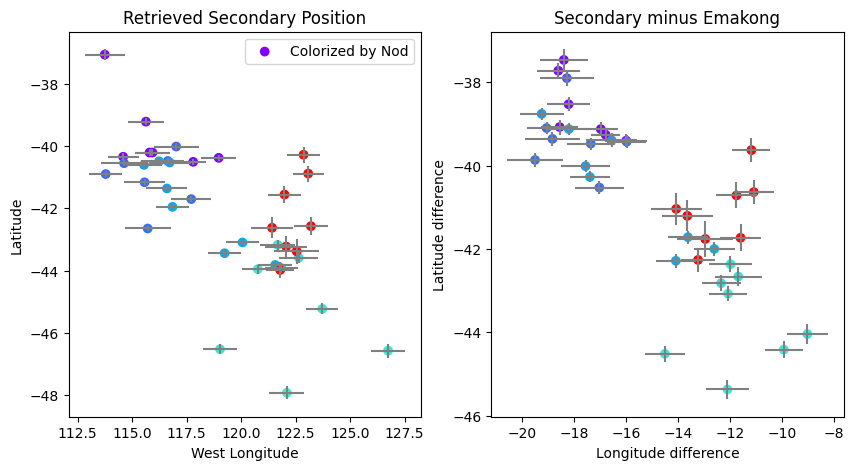

In [82]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,5))
ax0.errorbar(sec_lon, sec_lat, xerr=sig_dxss, yerr=sig_dyss, linestyle = '', color='gray')
ax0.scatter(sec_lon, sec_lat, c=lucky_angles, cmap='rainbow', label='Colorized by Nod')
ax0.set_xlabel('West Longitude')
ax0.set_ylabel('Latitude')
ax0.set_title('Retrieved Secondary Position')
ax0.legend()
   
dlon = np.array(sec_lon)-np.array(emakong_lon)
dlat = np.array(sec_lat)-np.array(emakong_lat)
ax1.scatter(dlon, 
            dlat, 
            c=lucky_angles, 
            cmap='rainbow', 
            label='Colorized by Nod')
ax1.errorbar(dlon, dlat, 
             xerr=np.sqrt(sig_dxss**2 + sig_dxs**2), 
             yerr=np.sqrt(sig_dyss**2 + sig_dys**2), 
             linestyle = '', 
             color='gray')
ax1.set_xlabel('Longitude difference')
ax1.set_ylabel('Latitude difference')
ax1.set_title('Secondary minus Emakong')
      
#fig.savefig('diagnostic_plots/theoretical_interferogram/retrieved_latlon.png', dpi=300)
plt.show()

yikes, now I need to explain why there is a separation by nod again... this could be due to lots of things.



### Cross-correlate Emakong and secondary feature retrievals

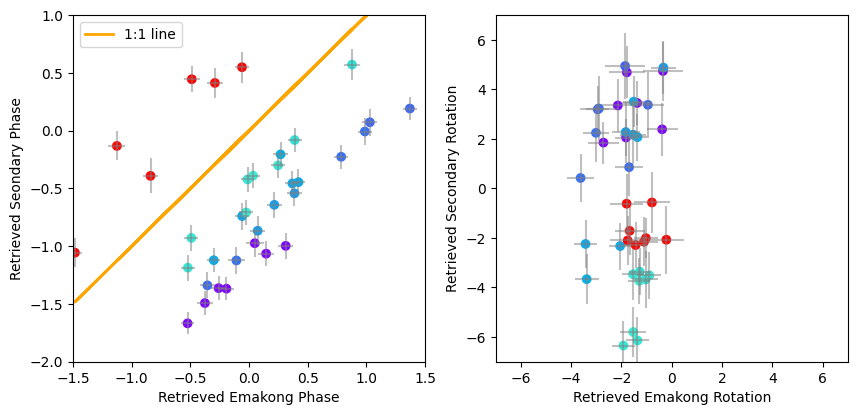

In [83]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,4.5))
ax0.scatter(phis, phiss, c=lucky_angles, cmap='rainbow')
ax0.errorbar(phis, phiss, yerr = sig_phiss, xerr=sig_phis, marker='', linestyle='', color='gray', alpha=0.5)
ax0.plot(phis, phis, linestyle='-', color='orange', label='1:1 line', linewidth=2)
ax0.set_xlim([-1.5, 1.5])
ax0.set_ylim([-2, 1])
ax0.set_xlabel('Retrieved Emakong Phase')
ax0.set_ylabel('Retrieved Seondary Phase')
ax0.legend()

ax1.scatter(rotangs, rotangss, c=lucky_angles, cmap='rainbow')
ax1.errorbar(rotangs, rotangss, yerr = sig_rotss, xerr=sig_rots, marker='', linestyle='', color='gray', alpha=0.5)
ax1.set_xlim([-7,7])
ax1.set_ylim([-7,7])
ax1.set_xlabel('Retrieved Emakong Rotation')
ax1.set_ylabel('Retrieved Secondary Rotation')
fig.savefig('diagnostic_plots/theoretical_interferogram/ema_vs_secondary.png', dpi=300)
plt.show()

## GIF of PSF as a function of phase

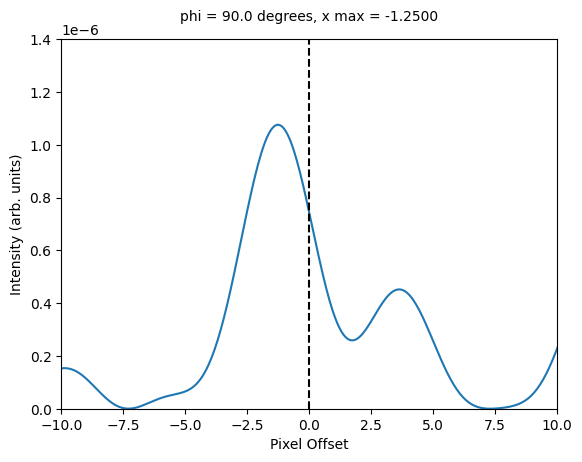

In [84]:
phases = np.linspace(-np.pi/2, np.pi/2, 50)
xfine = np.linspace(-12, 12, 12*32 + 1)
    
fig, ax = plt.subplots()
I = fit_eq(xfine, 1.0, 0.6, phases[0], 0.0)
l, = ax.plot(xfine, I) #I0, V, phi, dx
ax.set_xlim([-10, 10])
ax.set_ylim([0, 1.4e-6])
ax.axvline(0.0, color = 'k', linestyle = '--')
t = ax.text(0.5, 1.05, f'phi = {np.rad2deg(phases[0]):.1f} degrees, x max = {xfine[np.argmax(I)]:.4f}',
            transform=ax.transAxes, ha="center")
patches = [l] + [t]
ax.set_xlabel('Pixel Offset')
ax.set_ylabel('Intensity (arb. units)')

def init():
    #init lines
    l.set_data([], [])
    t.set_text('')

    return patches #return everything that must be updated

def animate(i):
    I = fit_eq(xfine, 1.0, 0.6, phases[i], 0.0)
    l.set_data(xfine, I)
    t.set_text(f'phi = {np.rad2deg(phases[i]):.1f} degrees, x max = {xfine[np.argmax(I)]:.4f}')
    return patches

ani = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, frames=len(phases), blit=True)

ani.save('phase.gif', writer='imagemagick')
plt.show()